# Regridding CMIP5 soil moisture mrlsl

This script performs linear interpolation on CMIP5 mrlsl data with the goal of creating a common
vertical coordinate system and integral down to 2.89 meters (see Python/format_era_soil_moisture.py).

The vertical interpolation is required due to the significantly varying depths and layers output in CMIP5 coupled models. These depths range between 3 and 14 meters (Berg et al. 2017). A good resource on just how different these models are can be found in [Berg et al. 2017](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016GL071921). Anyhow, we know what models with such different depths are probably not even trying to model the same thing, and that is just a weakness of this comparison. However, if there is skill there is skill, so we use these values, and will express them in terms of historical variance seen by ERA-Interim. 

#### This script will :
- Take all raw mrlsl files and regrid to a common vertical coordinate that matches Era-Interim Soil depths. 
- The soil moisture content of those layers (kg m$^{-2}$) will be integrated to the max depth in the new grid
- those data will be written as a netcdf file name mrlsl_integrated_"_other descriptors_".nc 
- Those data will then be processed the same way as all other CMIP5 NetCDF data, which is handled by Python/format_mip5_raw_data.py

### Detials on methods :
- Some CMIP5 data supply mrlsl as a masked array, where nans are given to the locations where the value does not apply or makes no sense, like the ocean. ACCESS models do this. Other models, will simply save those locations soil moisture values as 0 (e.g. GFDL). We choose to interpolate only the locations that are non-nan, and leave nan values as nan rather than converting them to 0. This difference between models handling of 0 and nan near the ocean will have an impact on regridded (remapbil) values near the ocean. The size of the effect is not known. We set grid boxes where the integrate soil moisture is 0 to nan- since there are clearly locations where the value of soil moisture content is not applicable. 

In [2]:
import numpy as np
import matplotlib.pylab as plt
import glob
from netCDF4 import Dataset
import os
import pandas as pd

### A look at what the np.interp function does, on a simple sin curve. 

In [3]:
# Set directory to load data from 
base_dir = "/Users/sbrey/GoogleDrive/sharedProjects/metSpreadData/getCMIP5"
raw_data_dir = os.path.join(base_dir, "r1i1p1_raw_downloaded_files/")

# And the files that need to be regridded, in a loop. 
mrlsl_files = glob.glob(os.path.join(raw_data_dir, "mrlsl_Lmon_*"))

In [4]:
# e.g.
print(mrlsl_files[0])

/Users/sbrey/GoogleDrive/sharedProjects/metSpreadData/getCMIP5/r1i1p1_raw_downloaded_files/mrlsl_Lmon_ACCESS1-0_historical_r1i1p1_185001-194912.nc


In [8]:
def vertical_interp(f) :
    """
    Function takes 4 dimensional soil moisture data [time, depth, lon, lat] 
    and linearly interpolates to a common siol depth down to 2.89 meters, then
    sums the soil moisture content of those layers, and saves these data as the
    on the same grid, sans the vertical coordinate. The new file has the same 
    name except a _integrated is added after the mrlsl. 

    Parameters
    ----------
        f : str, mrlsl netcdf file to be regriddded and integrated. 

    return
    ------
        M_interp : Regridded soil moisture with vertical layers. This is not
                   written, simply returned here for development and investigating
                   purposes. 
        new_soil_layer_middle : The bottom coordinates of the new soil moisture 
                                coordinates that were integrated over. 

    """
    
    print("regridding: " + f.split("/")[-1])
    
    # These bottom (extent) of the new layers. 
    new_soil_layer_bottom = np.array([0.07, .28, 1., 2.89])
    n_new_layers = len(new_soil_layer_bottom)
    print("New soil layer bottoms")
    print(new_soil_layer_bottom)

    # Open the netcdf file 
    nc = Dataset(f, 'r')
    lat = nc.variables["lat"]
    lon = nc.variables["lon"]
    time = nc.variables["time"]
    soil_layer_bottom = nc.variables["depth_bnds"][:][:,1]
    print("Old soil layer bottom")
    print(soil_layer_bottom)
    mrlsl = nc.variables["mrlsl"]

    # Get data of field 
    M = mrlsl[:]
    dims = M.shape
    
    # If these data are masked array, masked values need to be set to zero.
    # Many CMIP5 models do not use Nan but rather 0 in areas where this quantity
    # is zero (like the oceans). For consistent regridding, I set the models that
    # use nan values to zero. 
    if isinstance(M, np.ma.MaskedArray) : 

        np.ma.set_fill_value(M, fill_value=0)
        M_new = np.array(M)
        nan_mask = M.mask # True where values NaN
        M_new[nan_mask] = 0.
        M = M_new
        print("Setting masked values to zero for interp then masking before save. New max value %f" % np.max(M))
        
        was_masked = True
    else :
        was_masked = False

    # Make the new array shape
    M_interp = np.empty(shape=(len(time), n_new_layers, len(lat), len(lon)))
    mrlsl_integrated = np.zeros(shape=(len(time), len(lat), len(lon)))
    mrlsl_integrated[:] = np.nan # So that data are nan until proven otherwise 

    # TODO: Only interpolate over North America, to make code faster. 
    
    loopLats = np.where( (lat[:] > 18.) & (lat[:] < 72.) )[0]
    loopLons = np.where( (lon[:] > 175.) & (lon[:] < 318.) )[0]
    
    diff = np.zeros(shape=(len(time), len(lat), len(lon)))
    
    for t in range(len(time)) : 
        for y in loopLats :
            for x in loopLons :
                
                # Get original column
                soil_moisture_value = M[t, :, y, x]
                original_sum = np.sum(soil_moisture_value)
                
                # interpolate the column 
                M_interp[t, :, y, x] = np.interp(new_soil_layer_bottom, soil_layer_bottom, soil_moisture_value)
                new_column_sum = np.sum(M_interp[t, :, y, x])
                mrlsl_integrated[t, y, x] = new_column_sum
                
    if was_masked :
        # Information on non land areas where supplied, use that to remask.
        mrlsl_integrated[nan_mask[:,0,:,:]] = np.nan
    else :
        # We assume anywhere with an integrated water column equal to 0
        # to be ocean or some other area where soil moisture does not apply
        mrlsl_integrated[mrlsl_integrated==0] = np.nan
        
    ##################################################################    
    # Perform some sanity checks to make sure that no error occurred. 
    if np.nanmax(mrlsl_integrated) > 2888.33 :
        # max depth = 2.89 meters x 1000 kg m**-3 gives this threshold. 
        raise ValueError("Maximum value of integrated soil moisture exceeds mass if entire depth were water.")
    
    # Have any of the columns gained mass? 
    if np.nanmax( mrlsl_integrated - M.sum(axis=1) ) > 0.1 :
        raise ValueError("At least one column has gained mass after integration.")
    
    # Write the mrlsl_integrated data to a netcdf file with same attributes as original 
    outputFile = f.replace("mrlsl", "mrlsl.integrated")

    ncFile = Dataset(outputFile, 'w', format='NETCDF4')
    ncFile.description = 'Interpolated soil moisture integrated to 2.89 meters.'
    ncFile.location = 'Global'
    ncFile.createDimension('time',  len(time) )
    ncFile.createDimension('lat', len(lat) )
    ncFile.createDimension('lon', len(lon) )

    VAR_ = ncFile.createVariable("mrlsl_integrated", 'f4',('time', 'lat','lon'))
    VAR_.long_name = mrlsl.long_name
    VAR_.units = mrlsl.units

    # Create time variable
    time_ = ncFile.createVariable('time', 'i4', ('time',))
    time_.units = time.units
    time_.calendar = time.calendar

    # create lat variable
    latitude_ = ncFile.createVariable('lat', 'f4', ('lat',))
    latitude_.units = lat.units
    latitude_.axis = lat.axis

    # create longitude variable
    longitude_ = ncFile.createVariable('lon', 'f4', ('lon',))
    longitude_.units = lon.units
    longitude_.axis = lon.axis
    
    # Write the actual data to these dimensions
    VAR_[:]       = mrlsl_integrated
    time_[:]      = time[:]
    latitude_[:]  = lat[:]
    longitude_[:] = lon[:]

    # Close the new ncFile with interpolated integrated data 
    ncFile.close()

    # Close the original netcdf file connection where data was read from
    nc.close()

    # to inpsect, but not used   
    return mrlsl_integrated, M, M_interp

In [6]:
f = os.path.join(raw_data_dir, 'mrlsl_Lmon_GFDL-CM3_historical_r1i1p1_190001-190412.nc')
#f = os.path.join(raw_data_dir, 'mrlsl_Lmon_ACCESS1-0_historical_r1i1p1_185001-194912.nc')
print(f)

/Users/sbrey/GoogleDrive/sharedProjects/metSpreadData/getCMIP5/r1i1p1_raw_downloaded_files/mrlsl_Lmon_GFDL-CM3_historical_r1i1p1_190001-190412.nc


In [9]:
mrlsl_integrated, mrlsl, mrlsl_interpolated = vertical_interp(f)

regridding: mrlsl_Lmon_GFDL-CM3_historical_r1i1p1_190001-190412.nc
New soil layer bottoms
[0.07 0.28 1.   2.89]
Old soil layer bottom
[ 0.02  0.06  0.1   0.15  0.2   0.3   0.4   0.6   0.8   1.    1.4   1.8
  2.2   2.6   3.    4.    5.    6.    7.5  10.  ]


In [10]:
print(mrlsl_interpolated.shape)
print(mrlsl_integrated.shape)
print(mrlsl.shape)

(60, 4, 90, 144)
(60, 90, 144)
(60, 20, 90, 144)


In [11]:
d=mrlsl_integrated - mrlsl.sum(axis=1)

In [12]:
print(np.nanmax(mrlsl_integrated))
print(np.nanmax(mrlsl.sum(axis=1)))

328.37470350265505
4559.625


-0.502330108534079
-4168.838187122345


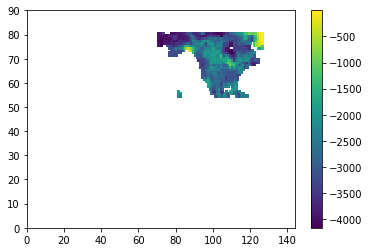

In [13]:
plt.pcolor(d[0,:,:])
plt.colorbar()
print(np.nanmax(d))
print(np.nanmin(d))

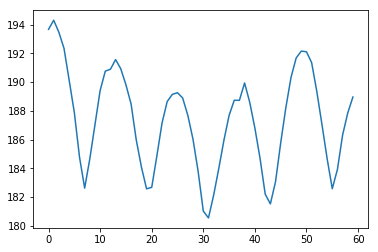

In [14]:
time_mean = np.nanmean(mrlsl_integrated, axis=(1,2))
plt.plot(time_mean)

In [ ]:
for f in mrlsl_files :
    _, _, _ = vertical_interp(f)
print("All files integrated!")

regridding: mrlsl_Lmon_ACCESS1-0_historical_r1i1p1_185001-194912.nc
New soil layer bottoms
[0.07 0.28 1.   2.89]
Old soil layer bottom
[0.1  0.35 1.   3.  ]
Setting masked values to zero for interp then masking before save. New max value 962.984253
regridding: mrlsl_Lmon_ACCESS1-0_historical_r1i1p1_195001-200512.nc
New soil layer bottoms
[0.07 0.28 1.   2.89]
Old soil layer bottom
[0.1  0.35 1.   3.  ]
Setting masked values to zero for interp then masking before save. New max value 962.984192
regridding: mrlsl_Lmon_ACCESS1-0_rcp45_r1i1p1_200601-210012.nc
New soil layer bottoms
[0.07 0.28 1.   2.89]
Old soil layer bottom
[0.1  0.35 1.   3.  ]
Setting masked values to zero for interp then masking before save. New max value 962.983276


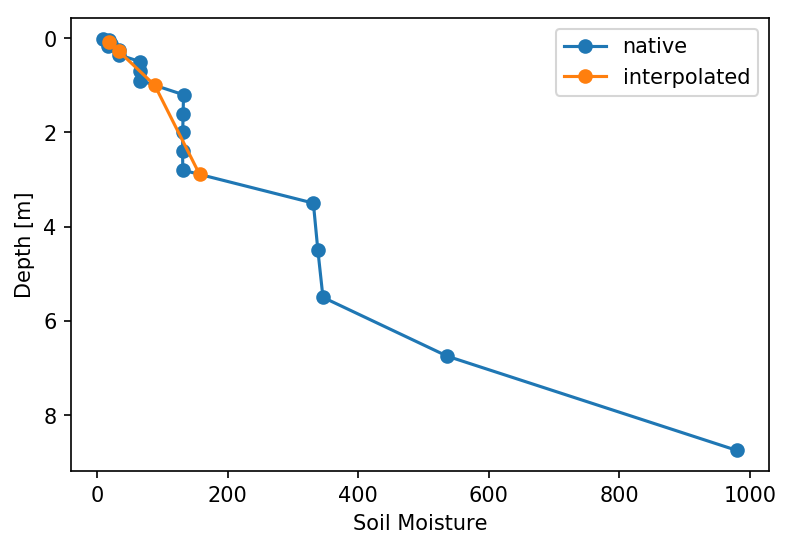

In [82]:
plt.figure(dpi=150)
plt.plot(soil_moisture_value, soil_layer_middle, "-o", label="native")
plt.plot(interp_soil_mostire_values, new_soil_layer_middle, "-o",label="interpolated")
plt.xlabel("Soil Moisture")
plt.ylabel("Depth [m]")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [16]:
files = glob.glob(os.path.join(raw_data_dir, "mrlsl_int*"))
for f in files :
    os.rename(f, f.replace("mrlsl_integrated", "mrlsl.integrated"))

In [15]:
files[0].replace("mrlsl_integrated", "mrlsl.integrated")

'/Users/sbrey/GoogleDrive/sharedProjects/metSpreadData/getCMIP5/r1i1p1_raw_downloaded_files/mrlsl.integrated_Lmon_ACCESS1-0_historical_r1i1p1_185001-194912.nc'

https://docs.scipy.org/doc/scipy-0.18.0/reference/generated/scipy.interpolate.RegularGridInterpolator.html#scipy.interpolate.RegularGridInterpolator